In [ ]:

import torch
import numpy as np


In [3]:
from sklearn.datasets import make_circles

n_samples = 1000
X, Y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)


In [4]:
len(X), len(Y)

(1000, 1000)

In [6]:
print(f"first 5 samples of X: \n {X[:5]}")
print(f"first 5 samples of Y: \n {Y[:5]}")

first 5 samples of X: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of Y: 
 [1 1 1 1 0]


In [9]:
import pandas as pd
circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": Y})
circles.head(10)

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


Text(0.5, 1.0, 'Make Circles Dataset')

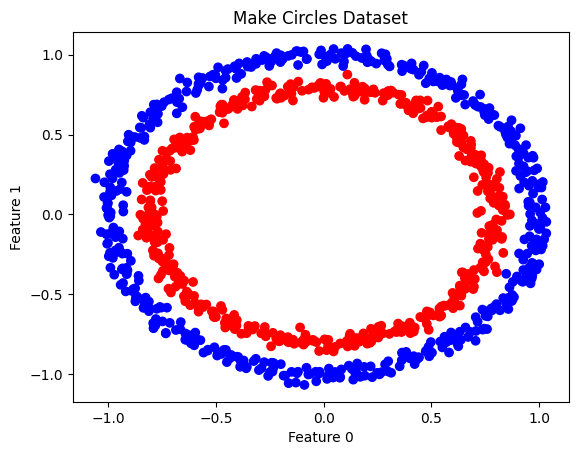

In [10]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=Y, cmap="bwr")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Make Circles Dataset")

In [13]:
X_sample = X[0]
Y_sample = Y[0]

print(f"Single sample of X: {X_sample}, label: {Y_sample}")
print(f"Shape of X: {X_sample.shape}, Shape of Y: {Y_sample.shape}")

Single sample of X: [0.75424625 0.23148074], label: 1
Shape of X: (2,), Shape of Y: ()


In [22]:
import numpy as np

# convert only if still numpy arrays

    
X = torch.from_numpy(X).float() if isinstance(X, np.ndarray) else X
Y = torch.from_numpy(Y).float() if isinstance(Y, np.ndarray) else Y

# View the first five samples
print(X[:5])
print(Y[:5])

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])
tensor([1., 1., 1., 1., 0.])


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(Y_train), len(Y_test)

(800, 200, 800, 200)

In [26]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory


'cuda'

In [38]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_1(x)
        x = nn.functional.relu(x)
        x = self.layer_2(x)
        return x
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [39]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(Y_test)}, Shape: {Y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{Y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.0202],
        [0.0098],
        [0.1209],
        [0.0302],
        [0.3008],
        [0.2996],
        [0.1330],
        [0.2077],
        [0.1121],
        [0.0114]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [40]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [41]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [42]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits



tensor([[0.0202],
        [0.0098],
        [0.1209],
        [0.0302],
        [0.3008]], device='cuda:0', grad_fn=<SliceBackward0>)

In [43]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5050],
        [0.5025],
        [0.5302],
        [0.5075],
        [0.5746]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [44]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [45]:
Y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [46]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 10000

# Put data to target device
X_train, y_train = X_train.to(device), Y_train.to(device)
X_test, y_test = X_test.to(device), Y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70128, Accuracy: 50.00% | Test loss: 0.69792, Test acc: 50.00%
Epoch: 10 | Loss: 0.69839, Accuracy: 52.00% | Test loss: 0.69578, Test acc: 56.50%
Epoch: 20 | Loss: 0.69689, Accuracy: 51.88% | Test loss: 0.69472, Test acc: 50.00%
Epoch: 30 | Loss: 0.69593, Accuracy: 51.38% | Test loss: 0.69406, Test acc: 49.00%
Epoch: 40 | Loss: 0.69520, Accuracy: 50.25% | Test loss: 0.69359, Test acc: 50.00%
Epoch: 50 | Loss: 0.69467, Accuracy: 49.75% | Test loss: 0.69326, Test acc: 51.00%
Epoch: 60 | Loss: 0.69427, Accuracy: 50.00% | Test loss: 0.69303, Test acc: 51.50%
Epoch: 70 | Loss: 0.69396, Accuracy: 49.50% | Test loss: 0.69289, Test acc: 50.50%
Epoch: 80 | Loss: 0.69373, Accuracy: 49.00% | Test loss: 0.69281, Test acc: 49.50%
Epoch: 90 | Loss: 0.69354, Accuracy: 49.38% | Test loss: 0.69274, Test acc: 49.50%
Epoch: 100 | Loss: 0.69338, Accuracy: 49.12% | Test loss: 0.69270, Test acc: 48.50%
Epoch: 110 | Loss: 0.69323, Accuracy: 48.75% | Test loss: 0.69266, Test acc: 48.50%
Epo

In [47]:
model_01 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_01

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

----

In [8]:
import os
# 11.0.0 forces the system to treat your card as the supported gfx1100 architecture
os.environ["HSA_OVERRIDE_GFX_VERSION"] = "11.0.0"

[[-1.37163899 -9.88001472]
 [-6.38140069  2.63470251]
 [-3.69434771 -4.69347074]
 [ 0.51073692 -1.25998604]
 [-2.47859494 -3.53433249]]
[0 3 4 1 2]


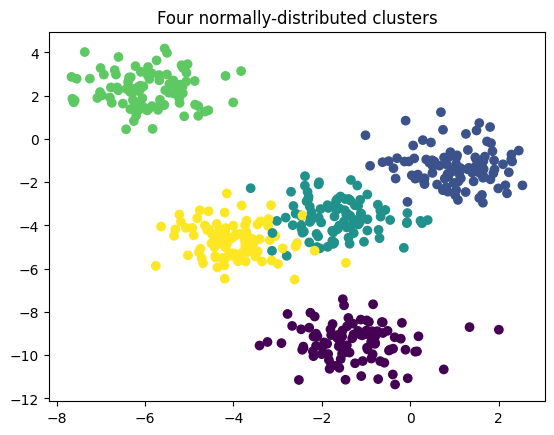

In [12]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=5, cluster_std=0.8, random_state=2, n_samples=500 ) # type: ignore

print(X[:5])
print(y[:5])

# plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(x=X[:, 0], y=X[:, 1], c=y)
plt.title("Four normally-distributed clusters")
plt.show()

In [13]:
import torch
import torch.nn as nn

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=5)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer_2(x)
        x = torch.nn.functional.relu(x)
        x = self.layer_3(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"

model_1 = CircleModelV1().to(device)
model_1
        

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=5, bias=True)
)

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [15]:
import pandas as pd

pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y}).head()

,X0,X1,label
0,-1.371639,-9.880015,0
1,-6.381401,2.634703,3
2,-3.694348,-4.693471,4
3,0.510737,-1.259986,1
4,-2.478595,-3.534332,2


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

epochs = 1000
for epoch in range(epochs):
    model_1.train()

    # Forward pass
    y_logits = model_1(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 

    # Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_score(y_true=y_train.cpu(), y_pred=y_pred.cpu())

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    # Optimizer step
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_1(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_score(y_true=y_test.cpu(), y_pred=test_pred.cpu())

    if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2%} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2%}")

Epoch: 0 | Loss: 1.76854, Acc: 18.50% | Test Loss: 1.69610, Test Acc: 26.00%
Epoch: 10 | Loss: 1.42410, Acc: 53.25% | Test Loss: 1.39694, Test Acc: 53.00%
Epoch: 20 | Loss: 1.02303, Acc: 73.25% | Test Loss: 1.02378, Test Acc: 63.00%
Epoch: 30 | Loss: 0.73846, Acc: 79.50% | Test Loss: 0.79382, Test Acc: 69.00%
Epoch: 40 | Loss: 0.53571, Acc: 80.50% | Test Loss: 0.61570, Test Acc: 71.00%
Epoch: 50 | Loss: 0.41983, Acc: 85.00% | Test Loss: 0.50009, Test Acc: 78.00%
Epoch: 60 | Loss: 0.35688, Acc: 88.50% | Test Loss: 0.43558, Test Acc: 84.00%
Epoch: 70 | Loss: 0.31877, Acc: 89.50% | Test Loss: 0.39594, Test Acc: 84.00%
Epoch: 80 | Loss: 0.29295, Acc: 91.00% | Test Loss: 0.36892, Test Acc: 86.00%
Epoch: 90 | Loss: 0.27371, Acc: 91.50% | Test Loss: 0.34876, Test Acc: 86.00%
Epoch: 100 | Loss: 0.25835, Acc: 92.25% | Test Loss: 0.33256, Test Acc: 86.00%
Epoch: 110 | Loss: 0.24530, Acc: 92.75% | Test Loss: 0.31866, Test Acc: 86.00%
Epoch: 120 | Loss: 0.23373, Acc: 93.00% | Test Loss: 0.30609, T

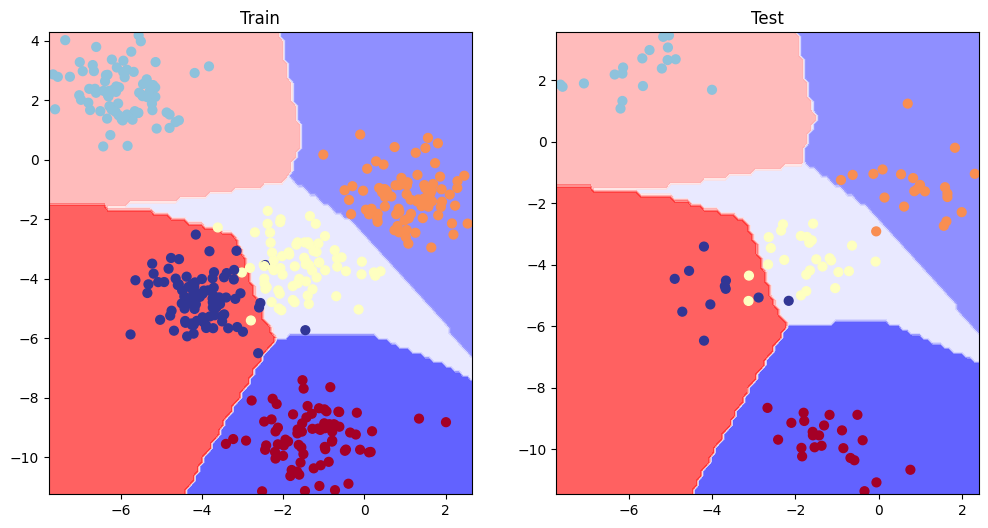

In [17]:
from helpers.helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)